In [68]:
#!/usr/bin/python
#DBR 01/22/2025

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' for copying

import os #for dealing with files
from PyPDF4 import PdfFileMerger, PdfFileReader #for merging lots of pdfs

import scipy.stats as st
import seaborn as sns
sns.set_style("ticks")

#extras for odes and fitting
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize


In [69]:
#read in 

odf = pd.read_csv('data/clean1-out.csv') #original all
vdf = pd.read_csv('data/clean1-out-viremic.csv') #viremic

In [70]:
'''[LONGITUDINAL]
input={Vt,b,th2,th3,phi1,phi2,I20}

Vt = {use=regressor}

EQUATION:
odeType=stiff

I1 = b*Vt/1000

I2_0 = I20
I3_0 = I20*phi2/th3

;productive cells 
ddt_I2 = phi1*I1 - (th2 + phi2)*I2
ddt_I3 = phi2*I2 - th3*I3

Itot = log10(I1+I2+I3)

OUTPUT:
output={Itot}'''

'[LONGITUDINAL]\ninput={Vt,b,th2,th3,phi1,phi2,I20}\n\nVt = {use=regressor}\n\nEQUATION:\nodeType=stiff\n\nI1 = b*Vt/1000\n\nI2_0 = I20\nI3_0 = I20*phi2/th3\n\n;productive cells \nddt_I2 = phi1*I1 - (th2 + phi2)*I2\nddt_I3 = phi2*I2 - th3*I3\n\nItot = log10(I1+I2+I3)\n\nOUTPUT:\noutput={Itot}'

In [71]:
#function that solves ODES, can change teval depending where you want points in sol

truemin=2 #for monolix I didn't adjust this

def get_sol(tt,Vt,teval,LOD,truemin,params):
    
    b,th2,th3,phi1,phi2,I20 = params
    
    # Create an interpolator function for u(t)
    u_t = interp1d(tt, 10**Vt, fill_value='extrapolate', kind='linear')
    
    #make model, but with u_t -- need this to be nested because depends on data
    def model(t, y):
        Ut = u_t(t)  # Interpolate the value of u(t) at time t
        
        #LOD vs true VL
        if Ut==LOD:
            Ut=truemin
        
        I2,I3 = y
        
        I1 = b*Ut/1000

        '''if A<0:
            A=0
        if L<0:
            L=0'''
            
        ddt_I2 = phi1*I1 - (th2 + phi2)*I2
        ddt_I3 = phi2*I2 - th3*I3
        
        return [ddt_I2,ddt_I3]

    I2_0 = I20
    I3_0 = I20*phi2/th3

    #solve, use same t values as in interpolated V, or u_t
    sol = solve_ivp(model, [tt[0],tt[-1]], [I2_0,I3_0], method='LSODA', t_eval=teval)
    
    I1 = u_t(tt)*b/1000  # Interpolate the value of u(t) at time t

    return I1,sol


#function to calculate error, need to figure out how to only output timepoints
def getRSS(data,model):
    # Calculate residual sum of squares (RSS)
    residuals = data - model
    
    #rss = np.sum(residuals**2/np.std(I_data_fit)**2)
    rss = np.sum(residuals**2)/len(data)
    
    return rss


In [72]:
#optimum parameters from monolix

mdfI = pd.read_csv('monolix/splineI-viremic-more123/IndividualParameters/estimatedIndividualParameters.txt')
mdfD = pd.read_csv('monolix/splineD-viremic-more123/IndividualParameters/estimatedIndividualParameters.txt')


120 65 55
intact b MannwhitneyuResult(statistic=792.0, pvalue=0.6287502814429398)
defect b MannwhitneyuResult(statistic=782.0, pvalue=0.7003738516469682)
intact th2 MannwhitneyuResult(statistic=794.0, pvalue=0.6148090894788841)
defect th2 MannwhitneyuResult(statistic=907.0, pvalue=0.10561950189143644)
intact th3 MannwhitneyuResult(statistic=819.0, pvalue=0.4533164023040782)
defect th3 MannwhitneyuResult(statistic=760.0, pvalue=0.8667876342970897)
intact phi1 MannwhitneyuResult(statistic=933.0, pvalue=0.06082796326027046)
defect phi1 MannwhitneyuResult(statistic=860.0, pvalue=0.2483167243814962)
intact phi2 MannwhitneyuResult(statistic=744.0, pvalue=0.9921273423807005)
defect phi2 MannwhitneyuResult(statistic=925.0, pvalue=0.07252516582858964)
intact I2(0) MannwhitneyuResult(statistic=928.0, pvalue=0.06793940127424368)
defect I2(0) MannwhitneyuResult(statistic=971.0, pvalue=0.02446845992822102)


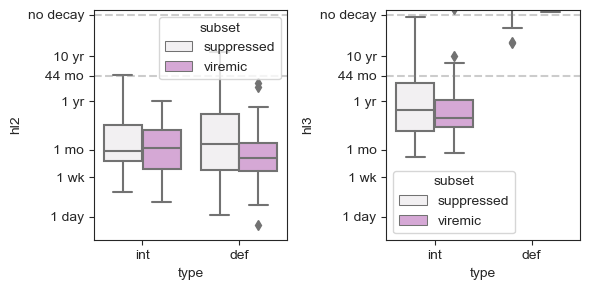

In [73]:
#check the decays split by group but estimated with the imputatino model

aids = odf['short_id'].unique() #all
vids = vdf['short_id'].unique() #viremic

sids = odf[~odf['short_id'].isin(vids)]['short_id'].unique()
    
print(len(aids),len(vids),len(sids))

mdfI['type']='int'
mdfD['type']='def'

fullpdf = mdfI.append(mdfD)

subset=[]
for i in range(len(fullpdf)):
    if fullpdf['id'].iloc[i] in vids:
        subset.append('viremic')
    else:
        subset.append('suppressed')

fullpdf['subset']=subset


#b,th2,th3,phi1,phi2,I20
labz=['b', 'th2', 'th3', 'phi1','phi2', 'I2(0)']

i=0
for pz in ['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']:
    #plt.figure(figsize=(4,3))
    #sns.boxplot(data=fullpdf, x='type',y=pz,hue='subset',color='purple')
    #plt.semilogy()
    #plt.ylabel(labz[i])
    
    #check p values
    print('intact',labz[i],st.mannwhitneyu(fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='int')][pz],
                                   fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='int')][pz]))
    print('defect',labz[i],st.mannwhitneyu(fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='def')][pz],
                                   fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='def')][pz]))
    i+=1
    
fullpdf['hl2']=np.log10(np.log(2)/fullpdf['th2_SAEM'])
fullpdf['hl3']=np.log10(np.log(2)/fullpdf['th3_SAEM'])
plt.figure(figsize=(6,3))
plt.subplot(121)
sns.boxplot(data=fullpdf, x='type',y='hl2',hue='subset',color='plum')
plt.yticks(np.log10([1/30,1/4,1,12,44,120,1000]),['1 day','1 wk','1 mo', '1 yr','44 mo', '10 yr','no decay'])
plt.axhline(3,ls='--',color='gray',alpha=0.4)
plt.axhline(np.log10(44),ls='--',color='gray',alpha=0.4)
plt.ylim(-2,3.1)

#plt.semilogy()
plt.subplot(122)
sns.boxplot(data=fullpdf, x='type',y='hl3',hue='subset',color='plum')
plt.yticks(np.log10([1/30,1/4,1,12,44,120,1000]),['1 day','1 wk','1 mo', '1 yr','44 mo', '10 yr','no decay'])
plt.axhline(3,ls='--',color='gray',alpha=0.4)
plt.axhline(np.log10(44),ls='--',color='gray',alpha=0.4)
plt.ylim(-2,3.1)

plt.tight_layout()
plt.savefig('figures/monolixparamsHL.svg')


In [74]:
pIz = pd.read_csv('monolix/splineI-viremic-more123/populationParameters.txt')
pIz

,parameter,value,CV,se_sa,rse_sa
0,b_pop,0.280155,NaN,0.092984,33.190331
1,th2_pop,0.382091,NaN,0.081087,21.221959
2,th3_pop,0.022128,NaN,0.015183,68.617751
3,phi1_pop,0.178963,NaN,0.097720,54.603466
4,phi2_pop,0.002616,NaN,0.001288,49.239324
5,I20_pop,8.180854,NaN,5.523417,67.516386
6,omega_b,2.371858,1662.735784,0.254374,10.724691
7,omega_th2,1.550593,317.350123,0.177540,11.449803
8,omega_th3,2.184339,1082.020482,0.925912,42.388664
9,omega_phi1,3.404205,32842.253457,0.471098,13.838714


In [75]:
#half-lifes
print(np.log(2)/pIz.iloc[1]['value'], np.log(2)/pIz.iloc[2]['value'])

1.8140899821746266 31.325140389089956


In [76]:
pDz = pd.read_csv('monolix/splineD-viremic-more123/populationParameters.txt')
pDz

,parameter,value,CV,se_sa,rse_sa
0,b_pop,1.077422,NaN,0.519379,48.205775
1,th2_pop,0.303314,NaN,0.084314,27.797459
2,th3_pop,0.000119,NaN,0.000022,18.386702
3,phi1_pop,0.079472,NaN,0.148099,186.353840
4,phi2_pop,0.000036,NaN,0.000006,15.865628
5,I20_pop,1047.721472,NaN,168.841687,16.115131
6,omega_b,2.743503,4308.322799,0.334219,12.182200
7,omega_th2,1.865083,560.465947,0.257480,13.805303
8,omega_th3,2.569298,230.768915,1.038837,40.432734
9,omega_phi1,10.812291,108.910887,6.142385,56.809279


In [77]:
#half-lifes
print(np.log(2)/pDz.iloc[1]['value'], np.log(2)/pDz.iloc[2]['value'])

2.2852425565639836 5823.365437461989


In [79]:
#check differential decay

print('suppressed th2',st.mannwhitneyu(fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='int')]['th2_SAEM'],
                                   fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='def')]['th2_SAEM']))

print('viremic th2',st.mannwhitneyu(fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='int')]['th2_SAEM'],
                                   fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='def')]['th2_SAEM']))

print('suppressed th2',st.mannwhitneyu(fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='int')]['th3_SAEM'],
                                   fullpdf[(fullpdf['subset']=='suppressed') & (fullpdf['type']=='def')]['th3_SAEM']))

print('viremic th2',st.mannwhitneyu(fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='int')]['th3_SAEM'],
                                   fullpdf[(fullpdf['subset']=='viremic') & (fullpdf['type']=='def')]['th3_SAEM']))


suppressed th2 MannwhitneyuResult(statistic=1574.0, pvalue=0.7153601109024204)
viremic th2 MannwhitneyuResult(statistic=316.0, pvalue=0.40631330215979167)
suppressed th2 MannwhitneyuResult(statistic=3002.0, pvalue=5.511787041731709e-19)
viremic th2 MannwhitneyuResult(statistic=727.0, pvalue=3.786315514685283e-10)


In [80]:
#plot ALL

###### plot of ODE fitting for selected participants in gpl2
for ip,p in enumerate(mdfI['id'].unique()):
    tdf=odf[odf['short_id']==p]
    tdf2=tdf.dropna()

    tt=tdf['ART_mo'].values #keep in months
    Vt=tdf['log10VL'].values
    t_data_fit = tdf2['ART_mo'].values
    I_data_fit = tdf2['log10int'].values
    D_data_fit = tdf2['log10def'].values

    LOD=np.min(Vt)
    
    czI,czD=['tab:orange','tab:blue']
    
    teval = tt#np.linspace(tt[0],tt[-1],10**4)

    pI = mdfI[mdfI['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1i,solI = get_sol(tt,Vt,teval,LOD,truemin,pI)

    pD = mdfD[mdfD['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1d,solD = get_sol(tt,Vt,teval,LOD,truemin,pD)

    plt.figure(figsize=(9,2))

    plt.subplot(151)
    
    Vt[Vt==LOD]=truemin
    plt.plot(tt,Vt,color='tab:purple',marker='.',ls='--')
    plt.ylim([0,9])
    plt.yticks(np.arange(9))
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.annotate(p,[1,7.5])
    plt.ylabel('log10 RNA/mL')

    plt.subplot(152)
    plt.plot(t_data_fit,I_data_fit,marker='o',ls='',color=czI,label='Observed')
    plt.plot(teval,np.log10(solI.y[0]+solI.y[1]+I1i),label='Model',ls='-',color=czI)
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()
    #plt.annotate('RSS/n='+str(np.round(RSSl[0][ip],3)),[1,0])
    plt.xticks(np.arange(0,101,20))
    
    plt.subplot(153)
    plt.plot(t_data_fit,D_data_fit,marker='o',ls='',color=czD,label='Observed')
    plt.plot(teval,np.log10(solD.y[0]+solD.y[1]+I1d),label='Model',ls='-',color=czD)
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.ylabel('log10 DNA/mCD4')
    plt.xlabel('Time (months since ART initiation)')
    #plt.legend()
    #plt.annotate('RSS/n='+str(np.round(RSSl[1][ip],3)),[1,0])
    plt.xticks(np.arange(0,101,20))

    plt.subplot(154)
    plt.plot(solI.t,np.log10(I1i),label='I1i',ls='-',color=czI)
    plt.plot(solI.t,np.log10(solI.y[0]),label='I2i',ls='-',color=czI)
    plt.plot(solI.t,np.log10(solI.y[1]),label='I3i',marker='',color='brown')
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()
    
    plt.subplot(155)
    plt.plot(solD.t,np.log10(I1d),label='I1d',ls='-',color=czD)
    plt.plot(solD.t,np.log10(solD.y[0]),label='I2d',ls='-',color=czD)
    plt.plot(solD.t,np.log10(solD.y[1]),label='I3d',marker='',color='navy')
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()

    plt.tight_layout()
    plt.savefig('figures/allsplinefits/'+str(p)+'.pdf',dpi=600)
    plt.close()
    
### merge the files into 1 giant pdf

fns = os.listdir('figures/allsplinefits/')
#fns.remove('.DS_Store')
fns.sort()

# Call the PdfFileMerger
mergedObject = PdfFileMerger()

# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for fn in fns:
    mergedObject.append(PdfFileReader('figures/allsplinefits/'+fn, 'rb'))

# Write all the files into a file which is named as shown below
mergedObject.write('../paper/SupplementaryData1-mergedfits-monolix.pdf')


In [ ]:
#NOTE censoring in plots

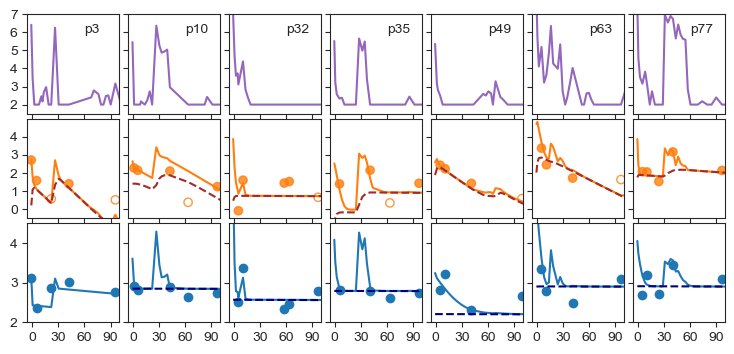

In [84]:
#plot differently...

#plot ALL

###### plot of ODE fitting for selected participants in gpl2
fig,axs = plt.subplots(3,7,sharex=True,sharey='row',figsize=(9,4))

ss = [3,10,32,35,49,63,77]

for ip,p in enumerate(ss):

    tdf=odf[odf['short_id']==p]
    tdf2=tdf.dropna()

    tt=tdf['ART_mo'].values #keep in months
    Vt=tdf['log10VL'].values
    t_data_fit = tdf2['ART_mo'].values
    I_data_fit = tdf2['log10int'].values
    D_data_fit = tdf2['log10def'].values
        
    LOD=np.min(Vt)
    
    czI,czD=['tab:orange','tab:blue']
    
    teval = tt #np.linspace(tt[0],tt[-1],10**4)

    pI = mdfI[mdfI['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1i,solI = get_sol(tt,Vt,teval,LOD,truemin,pI)

    pD = mdfD[mdfD['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1d,solD = get_sol(tt,Vt,teval,LOD,truemin,pD)
 
    Vt[Vt==LOD]=truemin
    
    axs[0][ip].plot(tt,Vt,color='tab:purple',marker='',ls='-')
    axs[0][ip].annotate('p'+str(p),[60,6],fontsize=10) #311000319

    Iu = tdf2['log10int'][tdf2['cens_intact']==0]
    tu = tdf2['ART_mo'][tdf2['cens_intact']==0]
    Ic = tdf2['log10int'][tdf2['cens_intact']==1]
    tc = tdf2['ART_mo'][tdf2['cens_intact']==1]
    
    #ax.scatter(tdf2['time_ART_mo'],10**tdf2['log10VL'],marker='o',color='none', edgecolor=cz, alpha=0.8)
    #ax.semilogy(tdf1['time_ART_mo'],10**tdf1['log10VL'],marker='o',label='VL',color=cz,ls='',lw=2,alpha=0.8)

    axs[1][ip].scatter(tu,Iu,marker='o',color=czI,ls='',lw=2,alpha=0.8)
    axs[1][ip].scatter(tc,Ic,marker='o',color='none', edgecolor=czI, alpha=0.8)
    
    axs[1][ip].plot(teval,np.log10(I1i+solI.y[0]+solI.y[1]),label='Model',ls='-',color=czI)
    axs[1][ip].plot(teval,np.log10(solI.y[1]),label='Model',ls='--',color='brown')
    
    #rss = getRSS(I_data_fit,np.log10(solI.y[0]+solI.y[1]))
    #axs[1][ip].annotate('RSS/n='+str(np.round(rss,3)),[1,4],fontsize=8)
    
    axs[2][ip].plot(t_data_fit,D_data_fit,marker='o',ls='',color=czD,label='Observed')
    axs[2][ip].plot(teval,np.log10(I1d+solD.y[0]+solD.y[1]),label='Model',ls='-',color=czD)
    axs[2][ip].plot(teval,np.log10(solD.y[1]),label='Model',ls='--',color='navy')
    
    #rss = getRSS(D_data_fit,np.log10(solD.y[0]+solD.y[1]))
    #axs[1][ip].annotate('RSS/n='+str(np.round(rss,3)),[1,4],fontsize=8)

axs[0][ip].set_yticks(np.arange(9))
axs[0][ip].set_ylim([1.5,7])
axs[0][ip].set_xlim([-5,100])
axs[0][ip].set_xticks(np.arange(0,96,30))

axs[1][ip].set_yticks([-1,0,1,2,3,4])
axs[1][ip].set_ylim([-0.5,5])

axs[2][ip].set_yticks([1,2,3,4])
axs[2][ip].set_ylim([2,4.5])

fig.subplots_adjust(hspace=0.05,wspace=0.1)
fig.savefig('figures/splinefitexamples.svg')#,dpi=600)


Text(0, 0.5, 'Defective creation rate')

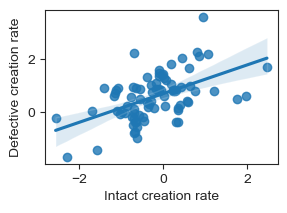

In [88]:
#correalte bI and bD?

plt.figure(figsize=(3,2))
sns.regplot(np.log10(mdfI['b_SAEM']),np.log10(mdfD['b_SAEM']))
#plt.scatter(np.array(opt_param)[:,0],np.array(opt_param_def)[:,0])
#plt.loglog()
plt.xlabel('Intact creation rate')
plt.ylabel('Defective creation rate')

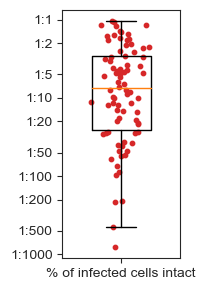

In [89]:
#ratio, fraction intact

brat = np.log10(mdfI['b_SAEM']/(mdfI['b_SAEM']+mdfD['b_SAEM']))

jit=0.1
plt.figure(figsize=(2,3))
plt.boxplot(brat,widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(brat)),brat,c='tab:red',s=10)
#plt.semilogy()
plt.yticks([-3,np.log10(1/500),np.log10(1/200),-2,np.log10(1/50),np.log10(1/20),-1,np.log10(1/5),np.log10(1/2),0,],['1:1000','1:500','1:200','1:100','1:50','1:20','1:10','1:5','1:2','1:1'])

plt.xticks([1],['% of infected cells intact'])
plt.tight_layout()
plt.savefig('figures/splinemodel-params-%int.pdf',dpi=600)

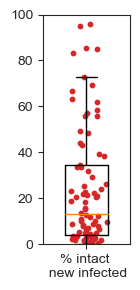

In [90]:
#ratio, fraction intact

brat = (mdfI['b_SAEM']/(mdfI['b_SAEM']+mdfD['b_SAEM']))*100

plt.figure(figsize=(1.5,3))
plt.boxplot(brat,widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(brat)),brat,c='tab:red',s=10)

plt.xticks([1],['% intact \n new infected'])
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/splinemodel-params-%int.svg',dpi=600)

In [91]:
print(np.min(brat),np.max(brat))

0.12355927559619508 95.95472702104804


In [102]:
#look at delta I3 vs VL AUC

outl=[]
for ip,p in enumerate(mdfI['id'].unique()):

    tdf=odf[odf['short_id']==p]
    tdf2=tdf.dropna()

    tt=tdf['ART_mo'].values #keep in months
    Vt=tdf['log10VL'].values
    t_data_fit = tdf2['ART_mo'].values
    I_data_fit = tdf2['log10int'].values
    D_data_fit = tdf2['log10def'].values
        
    LOD=np.min(Vt)
    
    czI,czD=['tab:orange','tab:blue']
    
    teval = tt #np.linspace(tt[0],tt[-1],10**4)

    pI = mdfI[mdfI['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1i,solI = get_sol(tt,Vt,teval,LOD,truemin,pI)

    pD = mdfD[mdfD['id']==p][['b_SAEM', 'th2_SAEM', 'th3_SAEM', 'phi1_SAEM', 'phi2_SAEM', 'I20_SAEM']].values[0] #use best param
    I1d,solD = get_sol(tt,Vt,teval,LOD,truemin,pD)
 
    delta_I=0; pct_dI=0
    if len(I_data_fit)>1:
        delta_I = I_data_fit[-1]-I_data_fit[0]
    
        pct_dI = delta_I/I_data_fit[0]
    
    drm = solI.y[1][-1] - solI.y[1][0] #delta from model
    
    Auc = np.trapz(Vt)/len(Vt)
    
    outl.append([Auc,drm,delta_I,pct_dI])
    
outdf=pd.DataFrame(outl,columns=['AUC','ΔI3(model)','ΔI3(data)','%ΔI3(data)'])

PearsonRResult(statistic=0.23198192537276832, pvalue=0.035981505555642876)


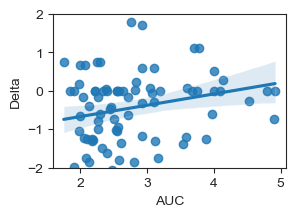

In [108]:
plt.figure(figsize=(3,2))
#sns.regplot(outdf['AUC'],outdf['ΔI3(model)'],label='model')
sns.regplot(outdf['AUC'],outdf['ΔI3(data)'],label='data')
print(st.pearsonr(outdf['AUC'],outdf['ΔI3(data)']))
#plt.legend()
plt.xlabel('AUC')
plt.ylabel('Delta')
plt.ylim([-2,2])

plt.savefig('figures/splinemodel-deltaAUC.svg',dpi=600)

PearsonRResult(statistic=-0.0638450740481419, pvalue=0.5687807869034904)


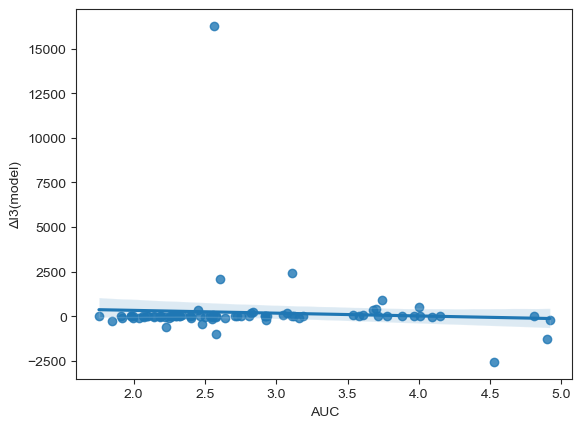

In [95]:
sns.regplot(outdf['AUC'],outdf['ΔI3(model)'],label='model')
print(st.pearsonr(outdf['AUC'],outdf['ΔI3(model)']))
